In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

# SCALES low-res SED example

This notebook runs through all the steps for generating a raw SCALES image using either:

(1) a target spectrum in erg/s/cm^2/um + a PSF
OR
(2) a model datacube with fluxes in erg/s/cm^2/um

You don't need to change any of the configuration stuff at the beginning if you don't want to. There are comments that describe some parameters that you might be interested in adjusting.

This example just uses PHOENIX models to set up simple stellar targets as "Target" objects. It then uses PHOENIX models to make an example model datacube that you can feed to the simulator. You can replace that with whatever scene you like, as long as the dimensions match the number of spaxels in each dimension (108 by 108), and the flux units are erg/s/cm^2/um. 

In the end it does a simple aperture extraction to generate a datacube. 

# SET UP OBSERVING MODE AND SCENE HERE

In [2]:
###Set your minimum and maximum wavelengths (in microns) here. 
###Realistic options (corresponding to planned modes) are: 2.0-5.2, 1.95-2.45, 2.0-4.0, 2.9-4.15, 3.1-3.5, 4.5-5.2 
wav_min = 4.5
wav_max = 5.2

###Set up a target spectrum to use with the SCALES PSF
T_s = 10000 #stellar temperature in K
logg = 4.5 #log surface gravity [cgs]
zz = 0.0 #metallicity 
rstar = 2.0 #stellar radius in solar radii
dstar = 100.0 #distance in pc

wav,I_lam = phoenix_star(T_s,logg,zz,rstar,dstar)
print(wav)
print(I_lam)

####set this up as a Target
targ = Target(wav,I_lam)

###Set up a scene instead of assuming a single point source with a spectrum
##make spectrum first
T_s = 10000 #stellar temperature in K
logg = 4.5 #log surface gravity [cgs]
zz = 0.0 #metallicity 
rstar = 2.0 #stellar radius in solar radii
dstar = 100.0 #distance in pc

wav,I_lam = phoenix_star(T_s,logg,zz,rstar,dstar)

lams_binned=np.linspace(1.9,5.3,3401) ###do not change
I_lam2 = spectres(lams_binned,wav,I_lam)

##create empty cube for scene
scene = np.zeros([len(lams_binned),17,18])

##central point source
scene[:,9,9] = I_lam2

##equal contrast companion
scene[:,14,14] = I_lam2


[0.05     0.05001  0.05002  ... 5.499925 5.49995  5.499975]
[1.2782357e-17 1.2860824e-17 1.2958242e-17 ... 1.2565723e-10 1.2565281e-10
 1.2564963e-10]


## Configure your H2RG

Load in h2rg configuration file 

In [3]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=2048, naxis2=2048,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [4]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [5]:
config.read('scales_h2rg_med.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

#arg_spaxel

In [6]:
arg_spaxel['min_wavelength'] = wav_min #minimum wavelength in microns
arg_spaxel['max_wavelength'] = wav_max #maximum wavelength in microns

## Set up lenslet traces

4.5_5.2_prism.txt
4.5_5.2_grism.txt


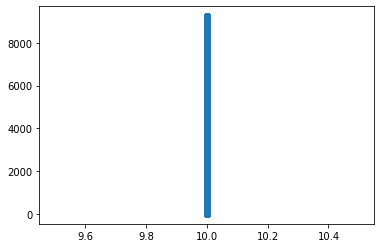

(3401, 9268, 38)
0 1.9 micron
1 1.9009999999999998 micron
2 1.902 micron
3 1.9029999999999998 micron
4 1.904 micron
5 1.9049999999999998 micron
6 1.906 micron
7 1.9069999999999998 micron
8 1.908 micron
9 1.9089999999999998 micron
10 1.91 micron
11 1.9109999999999998 micron
12 1.912 micron
13 1.9129999999999998 micron
14 1.914 micron
15 1.9149999999999998 micron
16 1.916 micron
17 1.9169999999999998 micron
18 1.918 micron
19 1.9189999999999998 micron
20 1.92 micron
21 1.9209999999999998 micron
22 1.922 micron
23 1.9229999999999998 micron
24 1.924 micron
25 1.9249999999999998 micron
26 1.926 micron
27 1.9269999999999998 micron
28 1.928 micron
29 1.9289999999999998 micron
30 1.93 micron
31 1.9309999999999998 micron
32 1.932 micron
33 1.9329999999999998 micron
34 1.934 micron
35 1.9349999999999998 micron
36 1.936 micron
37 1.9369999999999998 micron
38 1.938 micron
39 1.9389999999999998 micron
40 1.94 micron
41 1.9409999999999998 micron
42 1.942 micron
43 1.9429999999999998 micron
44 1.944 

412 2.312 micron
413 2.3129999999999997 micron
414 2.314 micron
415 2.315 micron
416 2.316 micron
417 2.3169999999999997 micron
418 2.318 micron
419 2.319 micron
420 2.32 micron
421 2.3209999999999997 micron
422 2.322 micron
423 2.323 micron
424 2.324 micron
425 2.3249999999999997 micron
426 2.326 micron
427 2.327 micron
428 2.328 micron
429 2.3289999999999997 micron
430 2.33 micron
431 2.331 micron
432 2.332 micron
433 2.3329999999999997 micron
434 2.334 micron
435 2.335 micron
436 2.336 micron
437 2.3369999999999997 micron
438 2.338 micron
439 2.339 micron
440 2.34 micron
441 2.3409999999999997 micron
442 2.342 micron
443 2.343 micron
444 2.344 micron
445 2.3449999999999998 micron
446 2.346 micron
447 2.347 micron
448 2.348 micron
449 2.3489999999999998 micron
450 2.35 micron
451 2.351 micron
452 2.352 micron
453 2.3529999999999998 micron
454 2.354 micron
455 2.355 micron
456 2.356 micron
457 2.3569999999999998 micron
458 2.358 micron
459 2.359 micron
460 2.36 micron
461 2.3609999999

841 2.7409999999999997 micron
842 2.742 micron
843 2.743 micron
844 2.7439999999999998 micron
845 2.745 micron
846 2.746 micron
847 2.747 micron
848 2.7479999999999998 micron
849 2.7489999999999997 micron
850 2.75 micron
851 2.751 micron
852 2.752 micron
853 2.753 micron
854 2.754 micron
855 2.755 micron
856 2.756 micron
857 2.7569999999999997 micron
858 2.758 micron
859 2.759 micron
860 2.76 micron
861 2.761 micron
862 2.762 micron
863 2.763 micron
864 2.764 micron
865 2.7649999999999997 micron
866 2.766 micron
867 2.767 micron
868 2.768 micron
869 2.769 micron
870 2.77 micron
871 2.771 micron
872 2.772 micron
873 2.7729999999999997 micron
874 2.774 micron
875 2.775 micron
876 2.776 micron
877 2.777 micron
878 2.778 micron
879 2.779 micron
880 2.78 micron
881 2.7809999999999997 micron
882 2.782 micron
883 2.783 micron
884 2.784 micron
885 2.785 micron
886 2.786 micron
887 2.787 micron
888 2.788 micron
889 2.7889999999999997 micron
890 2.79 micron
891 2.791 micron
892 2.792 micron
893 

1246 3.146 micron
1247 3.1470000000000002 micron
1248 3.1479999999999997 micron
1249 3.149 micron
1250 3.15 micron
1251 3.151 micron
1252 3.152 micron
1253 3.153 micron
1254 3.154 micron
1255 3.1550000000000002 micron
1256 3.1559999999999997 micron
1257 3.157 micron
1258 3.158 micron
1259 3.159 micron
1260 3.16 micron
1261 3.161 micron
1262 3.162 micron
1263 3.1630000000000003 micron
1264 3.1639999999999997 micron
1265 3.165 micron
1266 3.166 micron
1267 3.167 micron
1268 3.168 micron
1269 3.169 micron
1270 3.17 micron
1271 3.1710000000000003 micron
1272 3.1719999999999997 micron
1273 3.173 micron
1274 3.174 micron
1275 3.175 micron
1276 3.176 micron
1277 3.177 micron
1278 3.178 micron
1279 3.1790000000000003 micron
1280 3.1799999999999997 micron
1281 3.181 micron
1282 3.182 micron
1283 3.183 micron
1284 3.184 micron
1285 3.1849999999999996 micron
1286 3.186 micron
1287 3.187 micron
1288 3.1879999999999997 micron
1289 3.189 micron
1290 3.19 micron
1291 3.191 micron
1292 3.192 micron
12

1634 3.534 micron
1635 3.535 micron
1636 3.536 micron
1637 3.537 micron
1638 3.5380000000000003 micron
1639 3.5389999999999997 micron
1640 3.54 micron
1641 3.541 micron
1642 3.542 micron
1643 3.543 micron
1644 3.544 micron
1645 3.545 micron
1646 3.5460000000000003 micron
1647 3.5469999999999997 micron
1648 3.548 micron
1649 3.549 micron
1650 3.55 micron
1651 3.551 micron
1652 3.552 micron
1653 3.553 micron
1654 3.5540000000000003 micron
1655 3.5549999999999997 micron
1656 3.556 micron
1657 3.557 micron
1658 3.558 micron
1659 3.559 micron
1660 3.56 micron
1661 3.561 micron
1662 3.5620000000000003 micron
1663 3.5629999999999997 micron
1664 3.564 micron
1665 3.565 micron
1666 3.566 micron
1667 3.567 micron
1668 3.5679999999999996 micron
1669 3.569 micron
1670 3.57 micron
1671 3.5709999999999997 micron
1672 3.572 micron
1673 3.573 micron
1674 3.574 micron
1675 3.575 micron
1676 3.5759999999999996 micron
1677 3.577 micron
1678 3.578 micron
1679 3.5789999999999997 micron
1680 3.58 micron
168

2027 3.927 micron
2028 3.928 micron
2029 3.929 micron
2030 3.93 micron
2031 3.931 micron
2032 3.932 micron
2033 3.933 micron
2034 3.934 micron
2035 3.935 micron
2036 3.936 micron
2037 3.937 micron
2038 3.938 micron
2039 3.939 micron
2040 3.94 micron
2041 3.941 micron
2042 3.942 micron
2043 3.943 micron
2044 3.944 micron
2045 3.945 micron
2046 3.946 micron
2047 3.947 micron
2048 3.948 micron
2049 3.949 micron
2050 3.9499999999999997 micron
2051 3.951 micron
2052 3.952 micron
2053 3.953 micron
2054 3.9539999999999997 micron
2055 3.955 micron
2056 3.956 micron
2057 3.957 micron
2058 3.9579999999999997 micron
2059 3.959 micron
2060 3.96 micron
2061 3.961 micron
2062 3.9619999999999997 micron
2063 3.963 micron
2064 3.964 micron
2065 3.965 micron
2066 3.9659999999999997 micron
2067 3.967 micron
2068 3.968 micron
2069 3.969 micron
2070 3.9699999999999998 micron
2071 3.971 micron
2072 3.972 micron
2073 3.973 micron
2074 3.9739999999999998 micron
2075 3.975 micron
2076 3.976 micron
2077 3.977 m

2422 4.322 micron
2423 4.323 micron
2424 4.324 micron
2425 4.325 micron
2426 4.3260000000000005 micron
2427 4.327 micron
2428 4.327999999999999 micron
2429 4.329000000000001 micron
2430 4.33 micron
2431 4.3309999999999995 micron
2432 4.332 micron
2433 4.333 micron
2434 4.334 micron
2435 4.335 micron
2436 4.336 micron
2437 4.337 micron
2438 4.338 micron
2439 4.339 micron
2440 4.34 micron
2441 4.340999999999999 micron
2442 4.3420000000000005 micron
2443 4.343 micron
2444 4.343999999999999 micron
2445 4.345 micron
2446 4.346 micron
2447 4.3469999999999995 micron
2448 4.348 micron
2449 4.349 micron
2450 4.35 micron
2451 4.351 micron
2452 4.352 micron
2453 4.353 micron
2454 4.354 micron
2455 4.355 micron
2456 4.356 micron
2457 4.356999999999999 micron
2458 4.3580000000000005 micron
2459 4.359 micron
2460 4.359999999999999 micron
2461 4.361 micron
2462 4.362 micron
2463 4.3629999999999995 micron
2464 4.364 micron
2465 4.365 micron
2466 4.366 micron
2467 4.367 micron
2468 4.368 micron
2469 4.

2813 4.713 micron
2814 4.714 micron
2815 4.715 micron
2816 4.715999999999999 micron
2817 4.7170000000000005 micron
2818 4.718 micron
2819 4.718999999999999 micron
2820 4.72 micron
2821 4.721 micron
2822 4.7219999999999995 micron
2823 4.723 micron
2824 4.724 micron
2825 4.725 micron
2826 4.726 micron
2827 4.727 micron
2828 4.728 micron
2829 4.729 micron
2830 4.73 micron
2831 4.731 micron
2832 4.731999999999999 micron
2833 4.7330000000000005 micron
2834 4.734 micron
2835 4.734999999999999 micron
2836 4.736 micron
2837 4.737 micron
2838 4.7379999999999995 micron
2839 4.739 micron
2840 4.74 micron
2841 4.741 micron
2842 4.742 micron
2843 4.743 micron
2844 4.744 micron
2845 4.745 micron
2846 4.746 micron
2847 4.747 micron
2848 4.747999999999999 micron
2849 4.7490000000000006 micron
2850 4.75 micron
2851 4.7509999999999994 micron
2852 4.752 micron
2853 4.753 micron
2854 4.754 micron
2855 4.755 micron
2856 4.756 micron
2857 4.757 micron
2858 4.758 micron
2859 4.759 micron
2860 4.76 micron
286

3205 5.105 micron
3206 5.106 micron
3207 5.106999999999999 micron
3208 5.1080000000000005 micron
3209 5.109 micron
3210 5.109999999999999 micron
3211 5.111 micron
3212 5.112 micron
3213 5.1129999999999995 micron
3214 5.114 micron
3215 5.115 micron
3216 5.116 micron
3217 5.117 micron
3218 5.118 micron
3219 5.119 micron
3220 5.12 micron
3221 5.121 micron
3222 5.122 micron
3223 5.122999999999999 micron
3224 5.1240000000000006 micron
3225 5.125 micron
3226 5.1259999999999994 micron
3227 5.127 micron
3228 5.128 micron
3229 5.129 micron
3230 5.13 micron
3231 5.131 micron
3232 5.132 micron
3233 5.133 micron
3234 5.134 micron
3235 5.135 micron
3236 5.136 micron
3237 5.1370000000000005 micron
3238 5.138 micron
3239 5.138999999999999 micron
3240 5.140000000000001 micron
3241 5.141 micron
3242 5.1419999999999995 micron
3243 5.143 micron
3244 5.144 micron
3245 5.145 micron
3246 5.146 micron
3247 5.147 micron
3248 5.148 micron
3249 5.149 micron
3250 5.15 micron
3251 5.151 micron
3252 5.152 micron
3

In [7]:
lens = Lenslet(arg_spaxel, medium=True)
lens.get_shifts(rot = 0.0)
lens.make_trace(phys=True,verbose=True,upsample_factor=10)

## Read in Keck pupil

In [8]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck

## Filtered phase screen for toy AO correction

Can set screen1 to zeros to leave this out

In [9]:
screen = PhaseScreen(pupil=pupil, L0=10)
screen.sr_factor = screen.set_strehl(.8, 500e-9)
screen1 = screen.get_res()
#screen1 = np.zeros(screen1.shape)

## Use pupil and residual phase to generate cube of Keck PSFs

In [14]:
nspax = arg_spaxel['no_spaxel']
nlam = lens.trace.shape[0]

keck_cube = np.zeros((nlam, nspax-1, nspax))
mag1 = magn(lens.lmin)
mag2 = magn(lens.lmax)

psf_file = 'keck_psf_cube_'+str(lens.lmin)+'_'+str(lens.lmax)+'_n'+str(nlam)+'_med.fits'
if os.path.isfile(psf_file)==False:
    for i, mag in enumerate(np.linspace(mag1, mag2, nlam)):
        print(i)
        W = DFT_matrix(1600, mag)
        A = pupil.pupil * np.exp(1.j * screen1)
        out = abs(W.dot(A).dot(W))**2
        out /= np.sum(out, axis=(0,1))
        keck_cube[i] = frebin(out, (108, 108))[45:62,45:63]
    fits.writeto(psf_file,np.array(keck_cube),clobber=True)
else: keck_cube = pyfits.getdata(psf_file)
print(keck_cube.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


## Define some observational parameters

-Reads in sky transmission and emission models provided by Gemini for MK site: https://www.gemini.edu/observing/telescopes-and-sites/sites#IRSky

-Reads in atmospheric dispersion data based on relative humidity, temperature, pressure, and airmass

-Instrument transmission & emission includes SCALES + AO emissivity

-Default QE is 70%

-For now set up perfect filter with tophat from lmin to lmax

-Define single frame integration time in seconds

In [11]:
vapor = 1 #PWV in mm
airmass = 1 
skybg = SkyBG(vapor,airmass)
skytrans = SkyTrans(vapor,airmass)
atmodisp = AtmoDispersion(90,20,600)
inst_emissivities = [.08]*3 + [.01]*8
inst_temps = [273*u.K]*11
inst = InstTransEm(inst_emissivities, inst_temps)
qe = QE()
filt = Filter(lmin=lens.lmin,lmax=lens.lmax)
dit = 1 ###integration time in seconds

In [12]:
####organize all these and pass to focal_plane 
args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
fp = FocalPlane(args_new)

## Generate raw SCALES frame using target + PSF

making full raw image
nspax =  18
0
0 0
0.0 -0.14285714286052098
(1912, 12)
0 0
12 1912
0 1
0.0 -0.14285714286052098
(1912, 12)
18 0
30 1912
0 2
0.0 -0.14285714286052098
(1912, 12)
36 0
48 1912
0 3
0.0 -0.14285714286052098
(1912, 12)
54 0
66 1912
0 4
0.0 -0.14285714286052098
(1912, 12)
72 0
84 1912
0 5
0.0 -0.14285714286052098
(1912, 12)
90 0
102 1912
0 6
0.0 -0.14285714286052098
(1912, 12)
108 0
120 1912
0 7
0.0 -0.14285714286052098
(1912, 12)
126 0
138 1912
0 8
0.0 -0.14285714286052098
(1912, 12)
144 0
156 1912
0 9
0.0 -0.14285714286052098
(1912, 12)
162 0
174 1912
0 10
0.0 -0.14285714286052098
(1912, 12)
180 0
192 1912
0 11
0.0 -0.14285714286052098
(1912, 12)
198 0
210 1912
0 12
0.0 -0.14285714286052098
(1912, 12)
216 0
228 1912
0 13
0.0 -0.14285714286052098
(1912, 12)
234 0
246 1912
0 14
0.0 -0.14285714286052098
(1912, 12)
252 0
264 1912
0 15
0.0 -0.14285714286052098
(1912, 12)
270 0
282 1912
0 16
0.0 -0.14285714286052098
(1912, 12)
288 0
300 1912
1
1 0
0.0 0.5238095238061362
(1912

0.0 0.19047619047280762
(1912, 12)
1716 83
1728 1995
8 11
0.0 0.19047619047280762
(1912, 12)
1734 83
1746 1995
8 12
0.0 0.19047619047280762
(1912, 12)
1752 83
1764 1995
8 13
0.0 0.19047619047280762
(1912, 12)
1770 83
1782 1995
8 14
0.0 0.19047619047280762
(1912, 12)
1788 83
1800 1995
8 15
0.0 0.19047619047280762
(1912, 12)
1806 83
1818 1995
8 16
0.0 0.19047619047280762
(1912, 12)
1824 83
1836 1995
9
9 0
0.0 -0.14285714286052098
(1912, 12)
1530 0
1542 1912
9 1
0.0 -0.14285714286052098
(1912, 12)
1548 0
1560 1912
9 2
0.0 -0.14285714286052098
(1912, 12)
1566 0
1578 1912
9 3
0.0 -0.14285714286052098
(1912, 12)
1584 0
1596 1912
9 4
0.0 -0.14285714286052098
(1912, 12)
1602 0
1614 1912
9 5
0.0 -0.14285714286052098
(1912, 12)
1620 0
1632 1912
9 6
0.0 -0.14285714286052098
(1912, 12)
1638 0
1650 1912
9 7
0.0 -0.14285714286052098
(1912, 12)
1656 0
1668 1912
9 8
0.0 -0.14285714286052098
(1912, 12)
1674 0
1686 1912
9 9
0.0 -0.14285714286052098
(1912, 12)
1692 0
1704 1912
9 10
0.0 -0.142857142860520

0.0 0.19047619047280762
(1912, 12)
6 83
18 1995
17 1
0.0 0.19047619047280762
(1912, 12)
24 83
36 1995
17 2
0.0 0.19047619047280762
(1912, 12)
42 83
54 1995
17 3
0.0 0.19047619047280762
(1912, 12)
60 83
72 1995
17 4
0.0 0.19047619047280762
(1912, 12)
78 83
90 1995
17 5
0.0 0.19047619047280762
(1912, 12)
96 83
108 1995
17 6
0.0 0.19047619047280762
(1912, 12)
114 83
126 1995
17 7
0.0 0.19047619047280762
(1912, 12)
132 83
144 1995
17 8
0.0 0.19047619047280762
(1912, 12)
150 83
162 1995
17 9
0.0 0.19047619047280762
(1912, 12)
168 83
180 1995
17 10
0.0 0.19047619047280762
(1912, 12)
186 83
198 1995
17 11
0.0 0.19047619047280762
(1912, 12)
204 83
216 1995
17 12
0.0 0.19047619047280762
(1912, 12)
222 83
234 1995
17 13
0.0 0.19047619047280762
(1912, 12)
240 83
252 1995
17 14
0.0 0.19047619047280762
(1912, 12)
258 83
270 1995
17 15
0.0 0.19047619047280762
(1912, 12)
276 83
288 1995
17 16
0.0 0.19047619047280762
(1912, 12)
294 83
306 1995


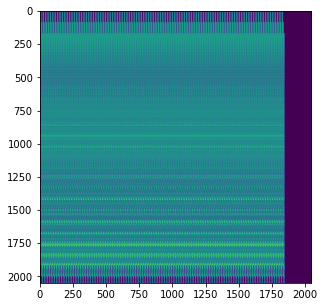

In [13]:
#raw, bg_star_truth = fp.get_fp(dit*u.s,targ,return_full=True,PSF=keck_cube,medium=True, verbose=True)
raw_bg, bg_star_truth = fp.get_fp(dit*u.s,return_full=True,medium=True,verbose=True)
rawfile = 'raw_frame_med_M.fits'
pyfits.writeto(rawfile,np.array(raw),clobber=True)

f = plt.figure(figsize=(5,5))
plt.imshow(raw**0.25)
plt.show()

making full raw image
nspax =  18
0
0 0
0.0 -0.14285714286052098
(1912, 12)
0 0
12 1912
0 1
0.0 -0.14285714286052098
(1912, 12)
18 0
30 1912
0 2
0.0 -0.14285714286052098
(1912, 12)
36 0
48 1912
0 3
0.0 -0.14285714286052098
(1912, 12)
54 0
66 1912
0 4
0.0 -0.14285714286052098
(1912, 12)
72 0
84 1912
0 5
0.0 -0.14285714286052098
(1912, 12)
90 0
102 1912
0 6
0.0 -0.14285714286052098
(1912, 12)
108 0
120 1912
0 7
0.0 -0.14285714286052098
(1912, 12)
126 0
138 1912
0 8
0.0 -0.14285714286052098
(1912, 12)
144 0
156 1912
0 9
0.0 -0.14285714286052098
(1912, 12)
162 0
174 1912
0 10
0.0 -0.14285714286052098
(1912, 12)
180 0
192 1912
0 11
0.0 -0.14285714286052098
(1912, 12)
198 0
210 1912
0 12
0.0 -0.14285714286052098
(1912, 12)
216 0
228 1912
0 13
0.0 -0.14285714286052098
(1912, 12)
234 0
246 1912
0 14
0.0 -0.14285714286052098
(1912, 12)
252 0
264 1912
0 15
0.0 -0.14285714286052098
(1912, 12)
270 0
282 1912
0 16
0.0 -0.14285714286052098
(1912, 12)
288 0
300 1912
1
1 0
0.0 0.5238095238061362
(1912

0.0 0.19047619047280762
(1912, 12)
1716 83
1728 1995
8 11
0.0 0.19047619047280762
(1912, 12)
1734 83
1746 1995
8 12
0.0 0.19047619047280762
(1912, 12)
1752 83
1764 1995
8 13
0.0 0.19047619047280762
(1912, 12)
1770 83
1782 1995
8 14
0.0 0.19047619047280762
(1912, 12)
1788 83
1800 1995
8 15
0.0 0.19047619047280762
(1912, 12)
1806 83
1818 1995
8 16
0.0 0.19047619047280762
(1912, 12)
1824 83
1836 1995
9
9 0
0.0 -0.14285714286052098
(1912, 12)
1530 0
1542 1912
9 1
0.0 -0.14285714286052098
(1912, 12)
1548 0
1560 1912
9 2
0.0 -0.14285714286052098
(1912, 12)
1566 0
1578 1912
9 3
0.0 -0.14285714286052098
(1912, 12)
1584 0
1596 1912
9 4
0.0 -0.14285714286052098
(1912, 12)
1602 0
1614 1912
9 5
0.0 -0.14285714286052098
(1912, 12)
1620 0
1632 1912
9 6
0.0 -0.14285714286052098
(1912, 12)
1638 0
1650 1912
9 7
0.0 -0.14285714286052098
(1912, 12)
1656 0
1668 1912
9 8
0.0 -0.14285714286052098
(1912, 12)
1674 0
1686 1912
9 9
0.0 -0.14285714286052098
(1912, 12)
1692 0
1704 1912
9 10
0.0 -0.142857142860520

0.0 0.19047619047280762
(1912, 12)
6 83
18 1995
17 1
0.0 0.19047619047280762
(1912, 12)
24 83
36 1995
17 2
0.0 0.19047619047280762
(1912, 12)
42 83
54 1995
17 3
0.0 0.19047619047280762
(1912, 12)
60 83
72 1995
17 4
0.0 0.19047619047280762
(1912, 12)
78 83
90 1995
17 5
0.0 0.19047619047280762
(1912, 12)
96 83
108 1995
17 6
0.0 0.19047619047280762
(1912, 12)
114 83
126 1995
17 7
0.0 0.19047619047280762
(1912, 12)
132 83
144 1995
17 8
0.0 0.19047619047280762
(1912, 12)
150 83
162 1995
17 9
0.0 0.19047619047280762
(1912, 12)
168 83
180 1995
17 10
0.0 0.19047619047280762
(1912, 12)
186 83
198 1995
17 11
0.0 0.19047619047280762
(1912, 12)
204 83
216 1995
17 12
0.0 0.19047619047280762
(1912, 12)
222 83
234 1995
17 13
0.0 0.19047619047280762
(1912, 12)
240 83
252 1995
17 14
0.0 0.19047619047280762
(1912, 12)
258 83
270 1995
17 15
0.0 0.19047619047280762
(1912, 12)
276 83
288 1995
17 16
0.0 0.19047619047280762
(1912, 12)
294 83
306 1995


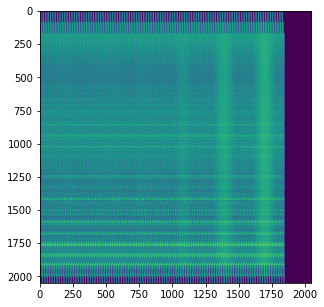

In [15]:
raw, bg_star_truth = fp.get_fp(dit*u.s,targ,return_full=True,PSF=keck_cube,medium=True, verbose=True)
#raw, bg_star_truth = fp.get_fp(dit*u.s,return_full=True,medium=True,verbose=True)
rawfile = 'raw_frame_med_M_A0star.fits'
pyfits.writeto(rawfile,np.array(raw),clobber=True)

f = plt.figure(figsize=(5,5))
plt.imshow(raw**0.25)
plt.show()